# Frequency of missed pairs

This script calculates and plots:

1. the frequency of missed photons 
2. the frequency of missed photons not identified by the bagplots areas (see description of derivative.R)

Input data: 

* simulations by xifupipeline of Crab-like sources at different fluxes
* detection maps for A1 and AD detection mechanisms
* areas where single and double pulses cannot be distinguished

This code runs along every photon in the list of input data and checks its energy and separation with previous and following pulses. Then it uses the information about the probability of being detected, from the SIRENA detection maps with detection mechanisms AD and A1. In case the photon under analysis is not detected, it also checks if these separations prevent us from noticing that it is in a double pulse.

In [96]:
rm(list=ls())
library(FITSio)
library(Hmisc)
source("~/R/Rfunctions/drawLogPlotBox.r")
setwd("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/baselineLPA2")


Define function to calculate if any of the elements of *vector* is closer to *value* than a given *distance*

In [97]:
is.closer.than <- function(vector,value,distance){
    # return TRUE if 'value' in closer than 'distance' 
    # (abs value) to any element in 'vector'
    res <- FALSE
    closest <- whichClosest(vector,value)
    res <- abs(vector[closest] - value) <= distance
    
}

## General changing variables:

   - **pdffile**: name of pdf for plotting
   - **timeRes**: time resolution
   - **libTemplates**: type of template library (many templates -def- or just a few - SHORT-)
   - **jitter**: jitter label to define simulated files. Bagplots data are simulated **without** jitter to be able to locate the pulses accurately, not relying on the detection performance. Pulses are reconstructed **with** jitter library.
   If *jitter* is on, detection maps correspond to jitter simulations
   - **EprimsMatrices**: energies of the primary pulses in the detection matrices (maps)
   - **EsecsMatrices**: energies of the secondary pulses in the detection matrices (maps)
   - **separationMatrices**: separations in samples between the two pulses in the doublet in the detection matrices (maps)
   - **EprimsBPs**: energies of the primary pulses in the bagplots maps
   - **EsecsBPs**: energies of the secondary pulses in the bagplots maps
   - **filterLengths**: length of the filters with which pairs would be reconstructed
   - **samprate**: sampling rate
   

In [98]:
timeRes <- 1E-6 #s
libTemplates <- "" # "" for full library or "_SHORT" for reduced library
jitter <- "_jitter" # or ''
samprateStr <- ""      # or '_samprate2'
pdffile <- paste("e2e/FrequencyPairsLogScale",jitter,samprateStr,libTemplates,".pdf",sep="")
# Energies where detection (AD/A1) matrices are calculated
EprimsMatrices <- c("0.2","1","2","2.5","4","4.5","6","6.5","8") 
EsecsMatrices  <- c("0.2","0.5","1","1.3","1.6","2","2.3","2.6",
                    "3","3.3","3.6","4","4.3","4.6","5","5.3",
                    "5.6","6","6.3","6.6","7","7.3","7.6","8") 
nSec <- length(EsecsMatrices)
nPrim <- length(EprimsMatrices)
# separations for pairs in Detection Matrices
if(samprateStr == ""){
    separationsMatrices <- c(4,5,7,10,14,20,28,39,54,75,105,146,202,281,
                         389,540,749,1039,1442,2000) # log scale
    filterLengths <- c("8192", "512", "256") # filters 
    samprate <- 156250 # Hz-1 - sampling rate
}else if(samprateStr == "_samprate2"){
    separationsMatrices <- c(2,3,5,7,10,14,19,27,37,52,73,101,140,194,
                         270,374,519,721,1000) # log scale
    filterLengths <- c("4096", "256", "128") # filters 
    samprate <- 78125 # Hz-1 - sampling rate
}
nseps <- length(separationsMatrices)
# Energies where baglots are calculated
EprimsBPs <- c("0.2","0.5","1","2","3","4","5","6","7","8") 
EsecsBPs  <- c("0.2","0.5","1","2","3","4","5","6","7","8") 


## Simulated Photons information (by xifupipeline)

- **EkeVrecons**: reconstructed energy of input photons 
- **evt.times**: event arrival times 
- **evt.phids**: event ids (in event file)
- **evt.pixids**: pixel ids (in event file)
- **phs.in.pix**:
- **pix.phids**: photon ID in piximpact file
- **detectionModes**: algorithm used by SIRENA for the detection in the maps
- **fluxes.mcrab**: simulated fluxes for the Crab-like sources (1mCrab= 2.11E-11 cgs 2-10)
- **filters**: presence/absence of Be filter in simulation

In [99]:
EkeVrecons <- list()
evt.times  <- numeric()
evt.phids  <- numeric()
evt.pixids <- numeric()
phs.in.pix <- numeric()
pix.phids  <- numeric()

detectionModes <- c("AD","A1")
nmodes <- length(detectionModes)
#flux210_mCrab=0.000000000021147 = 2.1147E-11 erg/cm2/s 2-10kev   ---> 1 mCrab 
fluxes.mcrab <- c("0.0001", "0.0005", "0.001", "0.005", "0.01", "0.036", "0.13", "0.46",
                  "0.60", "0.80", "1.67", "6.", "21.54", "77.43", "278.26", "1000.") # mCrab
nFluxes <- length(fluxes.mcrab)
filters <- c("_filter_", "_") # Be Filter & w/o filter
nfilters <- length(filters)
# info for the plots
legendTitles<-c("Be Filter","NO Be Filter")
legendPos <- c("topleft","top")
legendPch <- c(4,1)


## Conflicting detection areas
According to *bagplots* results, at some separations between the primary and secondary pulses, the reconstruction of the pair (i.e. mimicking the no detection of the secondary pulse) would produce a reconstructed energy similar to that of a single pulse with the primary pulse energy, with similar average of the 4 initial points of the derivative. Thus, using this average derivative (low energy estimator) and the reconstructed energy, it is not possible to differentiate single and double-baddetected pulses.

Save here lists of conflict areas, coming from bagplots script. Each cell contains the string list of *problematic separations* for a given Primary-pulse-energy (1st dimension), a given Secondary-pulse-energy (2nd dimension) and a given length of the reconstruction filter (3rd dimension).

In [100]:
#Create array 
BP.failAreasStr <- array(data=NA, dim=c(length(EprimsBPs),length(EsecsBPs),length(filterLengths)), 
                      dimnames = list(EprimsBPs,EsecsBPs,filterLengths))
# One file per secondary energy
for (ieSec in 1:length(EsecsBPs)){
    # for each secondary energy: read list of problematic bagplots
    Esec <- EsecsBPs[ieSec]
    fileBPfail <- paste("BPfail_",Esec,"keV",samprateStr,".dat",sep="")
    # load separationsToPlot from derivative.R
    load(fileBPfail)
    for (ie in 1:length(EprimsBPs)){
        for(ifl in 1:length(filterLengths)){
            BP.failAreasStr[ie,ieSec,ifl] <- separationsToPlot[ie,ifl]
            #cat("BP fail areas:",separationsToPlot[ie,ifl])
        }
    }
}


## Detection Probability from maps

Given a grid of pairs at different separations and different Primary&Secondary energies, SIRENA performed the detection of such pulses, following to different algorithms: AD and A1.
The probabilities of the detection of Primary and Secondary plots were saved in the corresponding matrices,  ```D_imageMatrix_<A1/AD>_<Eprim>keV_jitter<P/S>.fits```

In [101]:
# Initialize probability arrays (percentage of photons)
namesPercent  <- list(rep("",nFluxes), c("BeFilter", "NoFilter"), c("AD","A1"))
namesProb     <- list(EsecsMatrices, separationsMatrices,detectionModes, EprimsMatrices,
                      c("Prim","Sec"))
photonsMiss   <- array(data=NA, dim=c(nFluxes,nfilters,nmodes), dimnames = namesPercent)
photonsBPfail <- array(data=NA, dim=c(nFluxes,nfilters,nmodes), dimnames = namesPercent)
probDetMatrix <- array(data=NA, dim=c(nSec,nseps,nmodes,nPrim,2), dimnames = namesProb)
# Read probability matrices (0-100% --> 0-1)
for (i1 in 1:nPrim){
    for(idet in 1:nmodes){
        #primary probabilities
        matrixFilePrim <- paste("D_imageMatrix_",detectionModes[idet],"_",EprimsMatrices[i1],"keV",
                                libTemplates,jitter,"P.mat",sep="")
        load(matrixFilePrim)
        for(i2 in 1:nSec){
            for(is in 1:nseps){
                probDetMatrix[i2,is,idet,i1,1] <- mat_detectedPulsesP[i2,is]/100.                 
            }
        }
        #secondary probabilities
        matrixFileSec <- paste("D_imageMatrix_",detectionModes[idet],"_",EprimsMatrices[i1],"keV",
                               libTemplates,jitter,"S.mat",sep="")
        load(matrixFileSec)
        for(i2 in 1:nSec){
            for(is in 1:nseps){
                probDetMatrix[i2,is,idet,i1,2] <- mat_detectedPulsesS[i2,is]/100.
            }
        }
    }
}


## Processing
For each possible filter situation (Be filter or not) and for each source flux, read photon information (energy, arrival time, position in array/pixel) and determine the probability of being detected and the probability of being in a conflict area in case it is not detected.
```
foreach filter (Be):
   foreach source flux:
   
      1. Read piximpact info
      2. Read EVT info
      
      foreach detection mode (A1/AD):
         foreach pixel:
             List of photons in pixel
             
             foreach photon:
                 1. Probability of being detected
                 2. If not detected, is the pair in a conflict area?
```



### Detection Probability

<img src="tessim_pulses.png" width=250, align="left"> Let's analyse the pair **```ip-1(primary)```** $\leftrightarrow$ **```ip(secondary)```**, but taking also into account the pair **```ip-2(primary)```**$\leftrightarrow$ **```ip-1(secondary)```**. 

Imagine the detection maps provide detection probabilities 

- &nbsp;&nbsp;$P1_{ip-2}$: probability of detection of ```ip-2``` as primary in the pair ```ip-2```$\leftrightarrow$ ```ip-1```   
- &nbsp;&nbsp;$P2_{ip-1}$: probability of detection of ```ip-1``` as secondary in the pair ```ip-2```$\leftrightarrow$ ```ip-1```
- &nbsp;&nbsp;$P1_{ip-1}$: probability of detection of ```ip-1``` as primary in the pair ```ip-1```$\leftrightarrow$ ```ip```
- &nbsp;&nbsp;$P2_{ip}$: probability of detection of ```ip``` as secondary in the pair ```ip-1```$\leftrightarrow$ ```ip``` 
- &nbsp;&nbsp;$P22_{ip}$: probability of detection of ```ip``` as secondary in the pair ```ip-2```$\leftrightarrow$ ```ip``` 

Thus, to calculate $P_{ip}$, the pair **```ip-1(primary)```** $\leftrightarrow$ **```ip(secondary)```** will be considered $P2_{ip-1}$ times and the pair **```ip-2(primary)```** $\leftrightarrow$ **```ip(secondary)```** will be considered (1-$P2_{ip-1}$) times. The probability of the pulse **```ip-1```** should also be recalculated:

$P_{ip} = P2_{ip-1} \cdot P2_{ip} + (1-P2_{ip-1}) \cdot P22_{ip}$

$P_{ip-1} = P2_{ip-1} \cdot P1_{ip-1}$


### Conflicting Areas
If a given pulse **```ip```** is not detected, the loss could be mitigated if the reconstructed energy of the doublet **```ip-1(primary)```** $\leftrightarrow$ **```ip(secondary)```** is out of the region where single  pulses of the energy of the primary **```ip-1```** are. These regions are defined by the energies of the Primary and Secondary pulses, the filter length used for the reconstruction of the doublet in case the secondary is missing, and the separation between the components of the pulse. If we measure the average of the first 4 samples of the derivative for the pulse under analysis (**```ip-1```** $\leftrightarrow$ **```ip```**) and compare its reconstructed energy with single pulses with the same derivative average, we could check whether it can be rejected as a single pulse or not.

After the calculation of the detection probabilities, let's put the atention in pulse **```ip-1```** and calculate whether the BP flagging mechanism will fail to label it, in case of undetection.

1. If **```ip```** is detected ($P_{ip}$ times) 

    1. calculate the reconstruction filter: the pair **```ip-2```**$\leftrightarrow$ **```ip-1```** will be reconstructed with the largest filter (according to the grades) shorter than the distance between **```ip-2```**$\leftrightarrow$ **```ip```**.

    2. read the bagplot failing areas (coincident with single pulses)
    
    3. giving the (known) energy of **```ip-2```** and **```ip-1```** and the reconstruction filter, if the distance between **```ip-2```**$\leftrightarrow$ **```ip-1```** is in one of this conflictive areas (closer than 5 samples), we say that the BP mechanism would fail to identify the pileup.
    
    4. If the distance **```ip-2```**$\leftrightarrow$ **```ip```** is lower than the lowest filter, we would say that the flagging mechanism would not fail since these low res pulses, might not be even reconstructed
    
2. If **```ip```** is not detected (1-$P_{ip}$ times) 

    1. calculate the reconstruction filter: the pair **```ip-2```**$\leftrightarrow$ **```ip-1```** will be reconstructed with the largest filter in the gradind list (Hres).

    * read the bagplot failing areas (coincident with single pulses)
    
    * if the distance **```ip-2```**$\leftrightarrow$ **```ip```** is larger than the largest filter, the not-detection of **```ip```** does not influence the reconstruction of **```ip-2```**$\leftrightarrow$ **```ip-1```**. We follow step 2.D
    
    * giving the (known) energy of **```ip-2```** and **```ip-1```** and the reconstruction filter, if the distance between **```ip-2```**$\leftrightarrow$ **```ip-1```** is in one of this conflictive areas (closer than 5 samples), we say that the BP mechanism would fail to identify the pileup.
    
    * if the distance **```ip-2```**$\leftrightarrow$ **```ip```** is shorter than the largest filter, the not-detection of **```ip```** does influence the reconstruction of **```ip-2```**$\leftrightarrow$ **```ip-1```**, but the consideration of 3 doublets is complex, so we follow conservative approach and say that BP mechanism will fail
    
    
    
    
    

In [102]:
# Start processing
#==================
# allocate space for number of simulated photons
nsimsMat <- matrix(data=NA,nrow=nfilters, ncol=nFluxes)

for (ifi in 1:nfilters){
    cat("Working with filter ", filters[ifi],"\n")
    filter <- filters[ifi]
    for (ifl in 1:nFluxes){
        if(fluxes.mcrab[ifl] < 0.5) {
            # read evt file
            evtFile <- paste("e2e/crabSpec",fluxes.mcrab[ifl],"mCrab.fits",sep="")
            pixFile <- paste("e2e/crabSpec",fluxes.mcrab[ifl],"mCrab.piximpact",sep="")
        }else{
            
            evtFile <- paste("e2e/crabSpec",fluxes.mcrab[ifl],"mCrab",filter,"35mm.fits",sep="")
            pixFile <- paste("e2e/crabSpec",fluxes.mcrab[ifl],"mCrab",filter,"35mm.piximpact",sep="")
        }
        # READ PIXIMPACT file
        pp <- file(description = pixFile, open = "rb")
        header0 <- readFITSheader(pp, fixHdr = 'remove') # read primary header
        header <- readFITSheader(pp, fixHdr = 'remove') # read extension header
        pp.hdr <- parseHdr(header)
        evtTablePIX <- readFITSbintable(pp, header)
        close(pp)
        nsimsPIX <-as.numeric(pp.hdr[which(pp.hdr=="NAXIS2")+1]) # source photons simulated (in piximpact)
        # list of piximpact photons ids
        idcol.ph_id.pix <- which(evtTablePIX$colNames == "PH_ID")
        pix.phids <- evtTablePIX$col[[idcol.ph_id.pix]][1:nsimsPIX]
        nimps <- max(pix.phids)
        # piximpact energies
        idcol.energy.pix <- which(evtTablePIX$colNames == "ENERGY")
        #          setNames(as.list(values),                                           names)
        EkeVsim <- setNames(as.list(evtTablePIX$col[[idcol.energy.pix]][1:nsimsPIX]), pix.phids)
            
        # READ EVT file
        cat("Working with ", evtFile,"\n")
        zz <- file(description = evtFile, open = "rb")
        header0  <- readFITSheader(zz, fixHdr = 'remove') # read primary header
        header   <- readFITSheader(zz, fixHdr = 'remove') # read extension header
        zz.hdr   <- parseHdr(header)
        evtTable <- readFITSbintable(zz, header)
        close(zz)
        nsimsMat[ifi,ifl] <-as.numeric(zz.hdr[which(zz.hdr=="NAXIS2")+1]) # simulated photons in EVT
        nsims <- nsimsMat[ifi,ifl] 
        #stopifnot(nsimsPIX==nsims) 
        
        # list of EVT photons ids
        idcol.ph_id  <- which(evtTable$colNames == "PH_ID")
        evt.phids    <- evtTable$col[[idcol.ph_id]][1:nsims]
        # EVT energies (as list)
        idcol.signal <- which(evtTable$colNames == "SIGNAL")
        EkeVrecons   <- setNames(as.list(evtTable$col[[idcol.signal]][1:nsims]), evt.phids)
        idcol.time   <- which(evtTable$colNames == "TIME")
        evt.times    <- setNames(as.list(evtTable$col[[idcol.time]][1:nsims]), evt.phids)
        idcol.pixid  <- which(evtTable$colNames == "PIXID")
        evt.pixids   <- setNames(as.list(evtTable$col[[idcol.pixid]][1:nsims]), evt.phids)
        
        pixels <- unique(unlist(evt.pixids, use.names = F))
        
        for(idet in 1:nmodes){
            detMod <- detectionModes[idet]
            #cat(" Detection mode: ",detectionModes[idet],"\n")    
            #cat("   Photons loop (nsims=",nsims,"- nimps (max PH_ID in piximpact)=",nimps,")\n")
            probDetPh  <- setNames(as.list(rep(1,nsims)), evt.phids)
            probBPfail <- setNames(as.list(rep(0,nsims)), evt.phids)
            
            for (ipix in pixels){
                # which photons are in a given pixel? Time ordered list
                phs.in.pix <-as.character(evtTable$col[[idcol.ph_id]][evtTable$col[[idcol.pixid]]==ipix])
                #phs.in.pix <-as.character(evtTable$col[[idcol.ph_id]][evt.pixids==ipix]) # is the same?
                
                # how many?
                nphs <- length(phs.in.pix)
                # their initial probs
                if(nphs <= 1) next
                #cat("detMode=",detectionModes[idet],"  Flux=",fluxes.mcrab[ifl]," Pixel=", ipix, "  N.Photons=",nphs, "\n")
            
                for (ip in 2:nphs){
                    phName <- phs.in.pix[ip]
                    phNamePrev <- phs.in.pix[ip-1]

                    # save simulated energy instead of 0.00 energy
                    if(EkeVrecons[[phName]] == 0.0) EkeVrecons[[phName]] <- EkeVsim[[phName]]
                    BPfailsDet <- FALSE
                    BPfailsNoDet <- FALSE
                    
                    diffSamplesPrev <- (evt.times[[phName]]-evt.times[[phNamePrev]])*samprate
                    
                    # look for the closest energy of photons Prim & Sec and closest separation 
                    # in matrices 
                    idclosPrimMat <- whichClosest(EprimsMatrices,EkeVrecons[[phNamePrev]])
                    closestEnergyPrim <- EprimsMatrices[idclosPrimMat]
                    idclosSecMat  <- whichClosest(EsecsMatrices,EkeVrecons[[phName]])
                    closestEnergySec <- EsecsMatrices[idclosSecMat]
                    idclosSepMat  <- whichClosest(separationsMatrices,diffSamplesPrev)
                    closestSep <- separationsMatrices[idclosSepMat]
                    
                    if(diffSamplesPrev > max(as.numeric(filterLengths))){
                        probDetPrim <- 1.
                        probDetSec  <- 1.
                    }else{    
                        probDetPrim <- probDetMatrix[idclosSecMat,idclosSepMat,idet,idclosPrimMat,1] # 0-1 ip-1 <-> ip 
                        probDetSec  <- probDetMatrix[idclosSecMat,idclosSepMat,idet,idclosPrimMat,2] # 0-1 ip-1 <-> ip 
                    }
                    probDetSec2 <- 1. # 0-1 ip-2 <-> ip 
                    
                    # same but with ip-2 (just in case it has to be taken into account)
                    
                    if(ip>2){
                        phNamePrevPrev <- phs.in.pix[ip-2]
                        diffSamplesPrevPrev <- (evt.times[[phName]]-evt.times[[phNamePrevPrev]])*samprate
                        diffSamplesPrevPrevPrev <- (evt.times[[phNamePrev]]-evt.times[[phNamePrevPrev]])*samprate
                        idclosPrim2Mat <- whichClosest(EprimsMatrices,EkeVrecons[ip-2])
                        closestEnergyPrim2 <- EprimsMatrices[idclosPrim2Mat]
                        idclosSep2Mat <- whichClosest(separationsMatrices,diffSamplesPrevPrev)
                        closestSep2 <- separationsMatrices[idclosSep2Mat]
                        if(diffSamplesPrevPrev > max(as.numeric(filterLengths))){
                            probDetSec2 <- 1.
                        }else{
                            probDetSec2 <- probDetMatrix[idclosSecMat,idclosSep2Mat,idet,idclosPrim2Mat,2] # 0-100% ip-2 <->ip
                        }

                    }
                    
                    if(diffSamplesPrev <= timeRes) probDetSec <- 0.
                    # ip = secondary
                    # ip -1 = primary
                    
                    # Computed Probs in 0-1 scale 
                    probDetPh[[phName]] <- probDetPh[[phNamePrev]]*probDetSec 
                    #probDetPh[[phNamePrev]] <- probDetPh[[phNamePrev]]*probDetPrim 
                    probDetPh[[phName]] <- probDetPh[[phName]] + (1-probDetPh[[phNamePrev]])*probDetSec2
                    probDetPh[[phNamePrev]] <- probDetPh[[phNamePrev]]*probDetPrim 
                        
                    #if(fluxes.mcrab[ifl] == 0.01 && ipix==1954 && (phName=="327" || phName=="326")){    
                    #if(fluxes.mcrab[ifl] == 0.01 && (detectionModes[idet]=="AD" && (probDetPh[[phName]]<1 ||probDetPh[[phNamePrev]]<1 ))){    
                    #    cat("detMode=",detectionModes[idet]," ipix=",ipix,"\n")
                    #    cat("             ip=",phName," E=",EkeVrecons[[phName]]," Prob=", probDetPh[[phName]],"\n")
                    #    cat("             ip-1=",phNamePrev," E=",EkeVrecons[[phNamePrev]]," Prob=", probDetPh[[phNamePrev]],
                    #        " diffSamples",diffSamplesPrev," closestEnergySec=",closestEnergySec,
                    #        " closestEnergyPrim=",closestEnergyPrim,
                    #        " closestSep=",closestSep," probDetPrim=",probDetPrim," probDetSec=",probDetSec,"\n")
                    #}
                    # Once known phName -> look for the filter used for phNamePrev
                    #=============================================================
                    # => calculate bagplots (a posteriori)
                    if(ip>2){
                        # 1) look for the closest energy of photons Prim & Sec  in bagplots
                        idclosPrimBP <- whichClosest(EprimsBPs,EkeVrecons[[phNamePrevPrev]])
                        idclosSecBP  <- whichClosest(EsecsBPs,EkeVrecons[[phNamePrev]])
                        
                        # 2) For probDetPh[phName] times -> filter with length=diffSamplesPrevPrev will be used for 
                        # (phNamePrevPrev,phNamePrev) pair
                        if(diffSamplesPrevPrev < as.numeric(min(filterLengths))) {
                             closestFilDet <- "LRes"
                        }else{
                             closestFilDet <- max(filterLengths[as.numeric(filterLengths)<=diffSamplesPrevPrev])
                        }
                        idclosFilDet  <- which(filterLengths == closestFilDet)
                        #    For 1-probDetPh[phName] times -> filter with length=HighRes will be used for phNamePrev
                        closestFilNoDet <- max(filterLengths)
                        idclosFilNoDet  <- which(filterLengths == closestFilNoDet)
                        
                        # # 3) BPA1AD: Pulses not rejected by bagplots and not detected by A1/AD
                        # #===============================================================
                        # # if in same pixel than previous && in required temporal range (bagplots) for given
                        # #    energy prim/sec. 
                        # 
 
                        BPfailsDet <- FALSE
                        BPfailsNoDet <- FALSE
                        
                        # if phName is detected...
                        BP.failAreas <- unlist(strsplit(BP.failAreasStr[idclosPrimBP,idclosSecBP,idclosFilDet],","))
                        BP.failAreas <- as.numeric(BP.failAreas[BP.failAreas != ""])
                        if(length(BP.failAreas)>0){
                            # si está a menos de 5 muestras de una de las bolsas en la lista->fail
                            if(closestFilDet == "LRes"){
                                BPfailsDet <- FALSE  # flagged as Lres and possibly not reconstructed
                            }else if(is.closer.than(BP.failAreas,diffSamplesPrevPrevPrev,5)){
                                BPfailsDet <- TRUE
                            }
                        }

                        # if phName is not detected...
                        BP.failAreas <- unlist(strsplit(BP.failAreasStr[idclosPrimBP,idclosSecBP,idclosFilNoDet],","))
                        BP.failAreas <- as.numeric(BP.failAreas[BP.failAreas != ""])
                        if(length(BP.failAreas)>0){    
                            # check if phName would be in the reconstructon distance
                            if((diffSamplesPrevPrevPrev+diffSamplesPrev)>=closestFilNoDet) { #no problem: phName does not interfere
                                if(is.closer.than(BP.failAreas,diffSamplesPrevPrevPrev,5)) BPfailsNoDet <- TRUE
                            }else{ # pulse phName is not detected and enters in phNamePrevPrev-phNamePrev pair
                                # bagplots do not consider triple pulses...be conservative!
                                BPfailsNoDet <- TRUE
                            }     
                        }
                            
                        if(BPfailsDet){ # if not in 'bad area' probBPfail=0
                             probBPfail[[phNamePrev]] <- probDetPh[[phName]]*(1-probDetPh[[phNamePrev]])
                        }
                        if(BPfailsNoDet){ # if not in 'bad area' probBPfail=0
                            probBPfail[[phNamePrev]] <- probBPfail[[phNamePrev]] + 
                                (1-probDetPh[[phName]])*(1-probDetPh[[phNamePrev]]) 
                        }
                    }
                    
                    
                } #photons in pixel 
            } #pixels (given a ctrate and detection mode)
            photonsMiss[ifl,ifi,idet] <- sum(1-unlist(probDetPh, use.names = F)) 
            photonsBPfail[ifl,ifi,idet] <- sum(unlist(probBPfail, use.names = F))
        } #detMod
    } #each flux
}#each filter


Working with filter  _filter_ 
Working with  e2e/crabSpec0.0001mCrab.fits 
Working with  e2e/crabSpec0.0005mCrab.fits 
Working with  e2e/crabSpec0.001mCrab.fits 
Working with  e2e/crabSpec0.005mCrab.fits 
Working with  e2e/crabSpec0.01mCrab.fits 
Working with  e2e/crabSpec0.036mCrab.fits 
Working with  e2e/crabSpec0.13mCrab.fits 
Working with  e2e/crabSpec0.46mCrab.fits 
Working with  e2e/crabSpec0.60mCrab_filter_35mm.fits 
Working with  e2e/crabSpec0.80mCrab_filter_35mm.fits 
Working with  e2e/crabSpec1.67mCrab_filter_35mm.fits 
Working with  e2e/crabSpec6.mCrab_filter_35mm.fits 
Working with  e2e/crabSpec21.54mCrab_filter_35mm.fits 
Working with  e2e/crabSpec77.43mCrab_filter_35mm.fits 
Working with  e2e/crabSpec278.26mCrab_filter_35mm.fits 
Working with  e2e/crabSpec1000.mCrab_filter_35mm.fits 
Working with filter  _ 
Working with  e2e/crabSpec0.0001mCrab.fits 
Working with  e2e/crabSpec0.0005mCrab.fits 
Working with  e2e/crabSpec0.001mCrab.fits 
Working with  e2e/crabSpec0.005mCrab

# Plotting
Two different plots:

a) Percentage of missed photons for each detection method (A1 or AD), and using or not Be filter


In [103]:
pdf(pdffile)
par(mfrow=c(1,2))
subtit=paste("//",jitter,"//",samprateStr)

if(libTemplates == "_SHORT") {
    subtit <- "(SHORT lib templates)"
}
yminus <- as.numeric(nFluxes)
yplus  <- as.numeric(nFluxes)

# PLOTTING (UN)DETECTION
##########################
# draw log axes
y1max <- max(photonsMiss[,,]/nsims*100 + sqrt(photonsMiss[,,])/nsims*100)
drawLogPlotBox(xlimits=c(1E-4,1E3),ylimits=c(0,y1max), logxy="x",xlabel="Intensity (mCrab)",
               ylabel=expression("Fraction of photons (%)"), naxes=c(T,T,F,F))
title(main=paste("Undetected Fraction of Photons\n Crab spectrum",subtit,"\n"), cex.main=0.8,
      sub="1 mCrab=2.11E-11 erg/cm2/s 2-10kev",cex.sub=0.6)
# draw limit of difusion
abline(v=0.5,col="grey",lty=2)
for (ifi in 1:nfilters){
    for(idet in 1:nmodes){
        coldet<- "blue"
        if(detectionModes[idet] == "A1") coldet <- "red"
        points(fluxes.mcrab,photonsMiss[,ifi,idet]/nsimsMat[ifi,]*100, 
               col=coldet,type = "b",pch=legendPch[ifi],cex=0.8) 
        yminus <- photonsMiss[,ifi,idet]/nsims*100 - sqrt(photonsMiss[,ifi,idet])/nsims*100
        yplus  <- photonsMiss[,ifi,idet]/nsims*100 + sqrt(photonsMiss[,ifi,idet])/nsims*100
        suppressWarnings(arrows(as.numeric(fluxes.mcrab), yminus,as.numeric(fluxes.mcrab),yplus,
               col=coldet,lty=1,length=0.025, angle=90, code=3))
    }
}
# plot legend
legend("topleft",legend=c(paste(detectionModes[1],legendTitles[1]),
                          paste(detectionModes[2],legendTitles[1]),
                          paste(detectionModes[1],legendTitles[2]),
                          paste(detectionModes[2],legendTitles[2])),        
                col=c("blue","red","blue","red"),
                pch=c(legendPch[1],legendPch[1],legendPch[2],legendPch[2]),
                cex=0.7,bty="n")

text(1E-3,y1max/3.,"PSF=athena_psf_onaxis_20150602.fits",cex=0.4)
text(30,y1max/2.,"PSF=\nathena_ladapt_defocus_35mm_kev_psf_20161013.fits",cex=0.4)


b) Percentage of missed photons that could not be highlighted by the bagplots mechanism


pdf 
  3

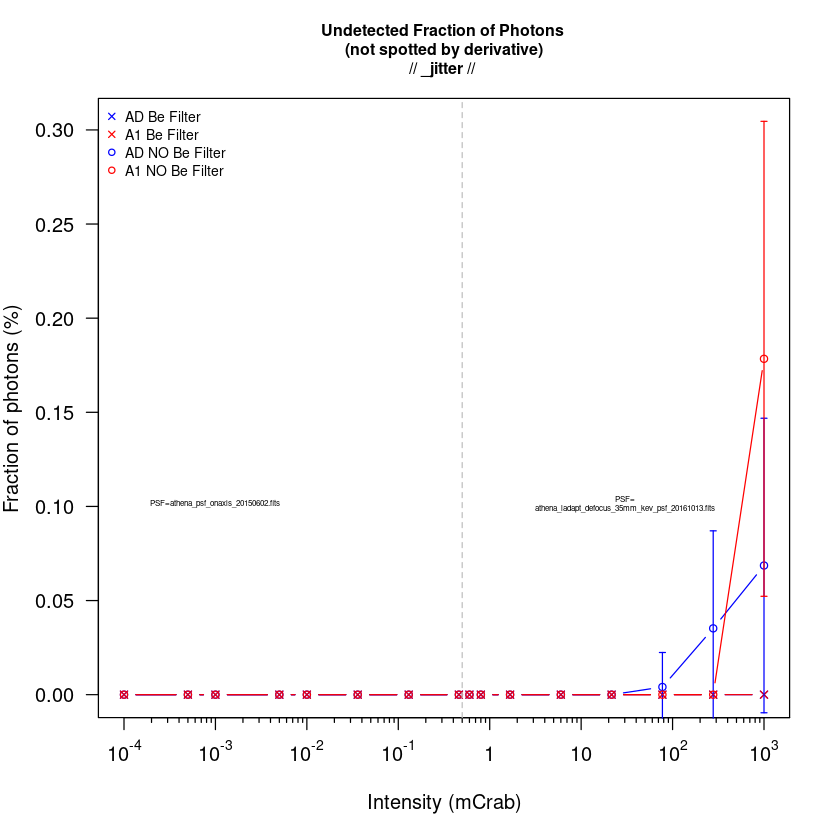

In [104]:
# PLOTTING (UN)DETECTION * BAGPLTS flagging
##############################################
y2max <- max(photonsBPfail[,,]/nsims*100 + sqrt(photonsBPfail[,,])/nsims*100)
drawLogPlotBox(xlimits=c(1E-4,1E3),ylimits=c(0,y2max), logxy="x",xlabel="Intensity (mCrab)", 
               ylabel=expression("Fraction of photons (%)"), naxes=c(T,T,F,F))
title(main=paste("Undetected Fraction of Photons \n(not spotted by derivative)",subtit,sep="\n"),
      cex.main=0.8)
for (ifi in 1:nfilters){
    for(idet in 1:nmodes){
        coldet<- "blue"
        if(detectionModes[idet] == "A1") coldet <- "red"
        points(fluxes.mcrab,photonsBPfail[,ifi,idet]/nsimsMat[ifi,]*100,col=coldet,lty=1,type = "b",pch=legendPch[ifi],cex=0.8)
        yminus <- photonsBPfail[,ifi,idet]/nsims*100 - sqrt(photonsBPfail[,ifi,idet])/nsims*100
        yplus  <- photonsBPfail[,ifi,idet]/nsims*100 + sqrt(photonsBPfail[,ifi,idet])/nsims*100
        suppressWarnings(arrows(as.numeric(fluxes.mcrab), yminus,as.numeric(fluxes.mcrab),yplus,
               col=coldet,lty=1,length=0.025, angle=90, code=3))
    }
}
#plot legend
legend("topleft",legend=c(paste(detectionModes[1],legendTitles[1]),
                          paste(detectionModes[2],legendTitles[1]),
                          paste(detectionModes[1],legendTitles[2]),
                          paste(detectionModes[2],legendTitles[2])),        
                          col=c("blue","red","blue","red"),
                          pch=c(legendPch[1],legendPch[1],legendPch[2],legendPch[2]),
                          cex=0.7,bty="n")
abline(v=0.5,col="grey",lty=2)
text(1E-3,y2max/3.,"PSF=athena_psf_onaxis_20150602.fits",cex=0.4)
text(30,y2max/3.,"PSF=\nathena_ladapt_defocus_35mm_kev_psf_20161013.fits",cex=0.4)
dev.off()